In [82]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count,col,mean

spark = SparkSession.builder.getOrCreate()

In [2]:
# in the file there is an error to parse a csv because  double double quotes: ""... ""
# we'll use sed for simplicity
!cat ./work/data/listings.csv | sed 's/""/'/g > ./work/data/listings_fixed.csv # !yes a quote is missing, its normal

In [83]:
listings_df = spark.read.option("header", "true").option("sep", ",").csv("./work/data/listings_fixed.csv")
loyer_df = spark.read.option("header", "true").option("sep",";").csv("./work/data/loyers.csv")

In [5]:
# count property_type
listings_df.groupBy("property_type").agg(count("property_type").alias("count")).sort("count", ascending=False).show(5)

+--------------------+-----+
|       property_type|count|
+--------------------+-----+
|  Entire rental unit|61032|
|                1125| 8026|
|Private room in r...| 4765|
|                 365| 3193|
|        Entire condo| 2040|
+--------------------+-----+
only showing top 5 rows



In [5]:
listings_df.groupBy("room_type").agg(count("room_type").alias("count")).sort("count", ascending=False).show(5)

+---------------+-----+
|      room_type|count|
+---------------+-----+
|Entire home/apt|64902|
|   Private room| 6976|
|           1125| 2478|
|            3.0| 1975|
|            1.0| 1896|
+---------------+-----+
only showing top 5 rows



In [84]:
listings_filter_cols_df = listings_df.select("id","room_type","price","availability_365", "longitude", "latitude", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "amenities", "availability_30", "availability_60", "availability_90", "availability_365")
listings_filter_cols_df = listings_filter_cols_df.filter(col("property_type") == "Entire rental unit").filter(col("room_type") == "Entire home/apt")
# filter na in cols 

In [85]:
listings_filter_cols_df.show(5)
panda_frame = listings_filter_cols_df.toPandas()
# parse price: replace '$' by '' and parse it to double
listings_filter_cols_df = listings_filter_cols_df.withColumn("price", col("price").substr(2, 100))
listings_filter_cols_df = listings_filter_cols_df.filter(col("price").isNotNull())

listings_filter_cols_df.show(5)

+-----+---------------+-------+----------------+---------+--------+------------------+---------------+------------+---------+--------+----+--------------------+---------------+---------------+---------------+----------------+
|   id|      room_type|  price|availability_365|longitude|latitude|     property_type|      room_type|accommodates|bathrooms|bedrooms|beds|           amenities|availability_30|availability_60|availability_90|availability_365|
+-----+---------------+-------+----------------+---------+--------+------------------+---------------+------------+---------+--------+----+--------------------+---------------+---------------+---------------+----------------+
| 3109|Entire home/apt|$113.00|             297|   2.3187|48.83191|Entire rental unit|Entire home/apt|           2|      1.0|       1|   1|[Cooking basics, ...|              6|             20|             35|             297|
| 5396|Entire home/apt| $95.00|              77|  2.35835|48.85247|Entire rental unit|Entire hom

In [86]:
# parse price,bathrooms, bedrooms, beds to double or na
listings_filter_cols_df = listings_filter_cols_df.withColumn("price", col("price").cast("double"))
listings_filter_cols_df = listings_filter_cols_df.withColumn("bathrooms", col("bathrooms").cast("double"))
listings_filter_cols_df = listings_filter_cols_df.withColumn("bedrooms", col("bedrooms").cast("double"))
listings_filter_cols_df = listings_filter_cols_df.withColumn("beds", col("beds").cast("double"))
# filter na in price, bathroom, bedrooms, beds
listings_filter_cols_df = listings_filter_cols_df.filter(col("price").isNotNull())
listings_filter_cols_df = listings_filter_cols_df.filter(col("bathrooms").isNotNull())
listings_filter_cols_df = listings_filter_cols_df.filter(col("bedrooms").isNotNull())
listings_filter_cols_df = listings_filter_cols_df.filter(col("beds").isNotNull())

# number of rows
print("Number of rows: ", listings_filter_cols_df.count())

Number of rows:  40336


In [87]:
# create number of rooms column
listings_filter_cols_df = listings_filter_cols_df.withColumn("number_of_rooms", col("bedrooms") + col("bathrooms") + 1) # add 1 for living room
# print mean number of rooms and min and max
listings_filter_cols_df.agg({"number_of_rooms": "min"}).show()
listings_filter_cols_df.agg(mean("number_of_rooms").alias("mean_number_of_rooms")).show()
listings_filter_cols_df.agg({"number_of_rooms": "max"}).show()

+--------------------+
|min(number_of_rooms)|
+--------------------+
|                 1.0|
+--------------------+

+--------------------+
|mean_number_of_rooms|
+--------------------+
|   3.405642602142007|
+--------------------+

+--------------------+
|max(number_of_rooms)|
+--------------------+
|                34.0|
+--------------------+



In [88]:
# estimate price per square meter, let's assume that a room is aprox 10m2
# knowing that the col 'price' is the price per night
# so the estimation to get the price per month per square meter is: price / (number_of_rooms * 10) * 30
# surface = number_of_rooms * 10
# price_per_m2 = price / surface
# price_per_m2_per_month = price_per_m2  * 30
listings_filter_cols_df = listings_filter_cols_df.withColumn("surface", col("number_of_rooms") * 10)
listings_filter_cols_df = listings_filter_cols_df.withColumn("price_per_m2", (col("price") / col("surface")) * 30)

# print min,mean,max price per m2
listings_filter_cols_df.agg({"price_per_m2": "min"}).show()
listings_filter_cols_df.agg(mean("price_per_m2").alias("mean_price_per_m2")).show()
listings_filter_cols_df.agg({"price_per_m2": "max"}).show()

+-----------------+
|min(price_per_m2)|
+-----------------+
|              3.0|
+-----------------+

+------------------+
| mean_price_per_m2|
+------------------+
|175.91001836451082|
+------------------+

+-----------------+
|max(price_per_m2)|
+-----------------+
|           2778.0|
+-----------------+



In [89]:
listings_filter_cols_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: string (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- amenities: string (nullable = true)
 |-- availability_30: string (nullable = true)
 |-- availability_60: string (nullable = true)
 |-- availability_90: string (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- number_of_rooms: double (nullable = true)
 |-- surface: double (nullable = true)
 |-- price_per_m2: double (nullable = true)



In [12]:
loyer_filter_cols_df = loyer_df.select("ref", "meuble_txt", "piece", "max", "min", "geo_point_2d")
loyer_filter_cols_df.select("meuble_txt").distinct().show()
loyer_filter_cols_df = loyer_filter_cols_df.filter(col("meuble_txt") == "meublé")
# then drop the column meuble_txt
loyer_filter_cols_df = loyer_filter_cols_df.drop("meuble_txt")
# parse ref, min, max to double
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("ref", col("ref").cast("double"))
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("min", col("min").cast("double"))
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("max", col("max").cast("double"))

loyer_filter_cols_df.show(5)
loyer_filter_cols_df.printSchema()

+----------+
|meuble_txt|
+----------+
|    meublé|
|non meublé|
+----------+

+----+-----+----+----+--------------------+
| ref|piece| max| min|        geo_point_2d|
+----+-----+----+----+--------------------+
|23.4|    4|28.1|16.4|48.82752745777257...|
|30.8|    1|37.0|21.6|48.87600829002058...|
|22.6|    4|27.1|15.8|48.85706404083103...|
|34.0|    3|40.8|23.8|48.85526326937375...|
|27.8|    2|33.4|19.5|48.82345277157510...|
+----+-----+----+----+--------------------+
only showing top 5 rows

root
 |-- ref: double (nullable = true)
 |-- piece: string (nullable = true)
 |-- max: double (nullable = true)
 |-- min: double (nullable = true)
 |-- geo_point_2d: string (nullable = true)



In [13]:
# to estimate the price we need the surface, so with the same estimation as above we can estimate the price
# and we'll use ref as price
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("surface", col("piece") * 10)
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("price_per_m2", (col("ref") / col("surface")) * 30)

# print min,mean,max price per m2
loyer_filter_cols_df.agg({"price_per_m2": "min"}).show()
loyer_filter_cols_df.agg(mean("price_per_m2").alias("mean_price_per_m2")).show()
loyer_filter_cols_df.agg({"price_per_m2": "max"}).show()

+------------------+
| min(price_per_m2)|
+------------------+
|12.075000000000001|
+------------------+

+-----------------+
|mean_price_per_m2|
+-----------------+
|45.68286783854164|
+-----------------+

+------------------+
| max(price_per_m2)|
+------------------+
|122.10000000000001|
+------------------+



# Plot

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

loyer_pd = loyer_filter_cols_df.toPandas()
listings_pd = listings_filter_cols_df.toPandas()

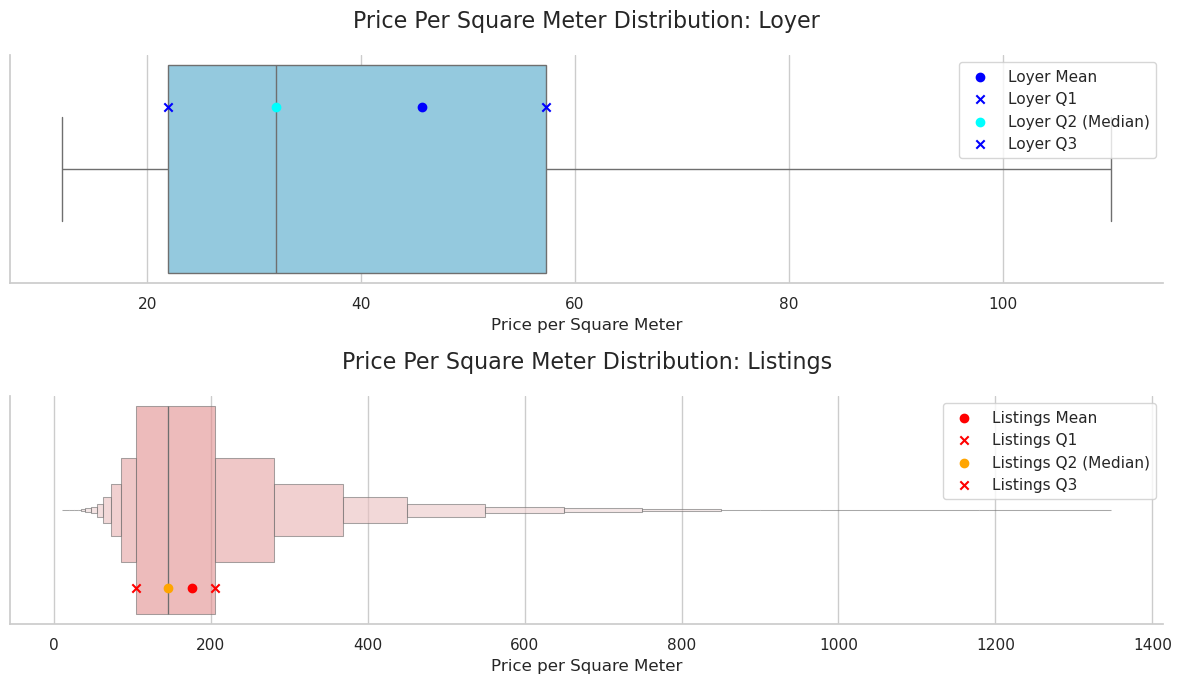

In [85]:
def boxplot_different_graph(loyer_pd, listings_pd):
    # Set a clean, modern style
    sns.set_theme(style="whitegrid")

    # Calculate special points for loyer_pd
    loyer_summary = loyer_pd['price_per_m2'].describe()
    loyer_mean = loyer_pd['price_per_m2'].mean()

    # Calculate special points for listings_pd
    listings_summary = listings_pd['price_per_m2'].describe()
    listings_mean = listings_pd['price_per_m2'].mean()

    # Create the figure and axes
    fig, axes = plt.subplots(2, 1, figsize=(12, 7))

    # Plot the boxplot for 'price_per_m2' in loyer_pd
    sns.boxplot(
        x='price_per_m2', 
        data=loyer_pd, 
        color="skyblue", 
        width=0.5, 
        showfliers=False,  # Hide outliers for clarity
        boxprops={'zorder': 2},  # Ensure boxplot is on top layer
        ax=axes[0]
    )
    axes[0].scatter(loyer_mean, -0.15, color="blue", label="Loyer Mean", zorder=3)
    axes[0].scatter(loyer_summary['25%'], -0.15, color="blue", marker="x", label="Loyer Q1", zorder=3)
    axes[0].scatter(loyer_summary['50%'], -0.15, color="cyan", marker="o", label="Loyer Q2 (Median)", zorder=3)
    axes[0].scatter(loyer_summary['75%'], -0.15, color="blue", marker="x", label="Loyer Q3", zorder=3)
    axes[0].set_title("Price Per Square Meter Distribution: Loyer", fontsize=16, pad=20)
    axes[0].set_xlabel("Price per Square Meter", fontsize=12)
    axes[0].legend(loc="upper right")
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)

    # Plot the boxenplot for 'price_per_m2' in listings_pd
    sns.boxenplot(
        x='price_per_m2', 
        data=listings_pd, 
        color="lightcoral", 
        width=0.4, 
        alpha=0.6,  # Slight transparency to show overlap
        showfliers=False,  # Hide outliers for clarity
        ax=axes[1]
    )
    axes[1].scatter(listings_mean, 0.15, color="red", label="Listings Mean", zorder=3)
    axes[1].scatter(listings_summary['25%'], 0.15, color="red", marker="x", label="Listings Q1", zorder=3)
    axes[1].scatter(listings_summary['50%'], 0.15, color="orange", marker="o", label="Listings Q2 (Median)", zorder=3)
    axes[1].scatter(listings_summary['75%'], 0.15, color="red", marker="x", label="Listings Q3", zorder=3)
    axes[1].set_title("Price Per Square Meter Distribution: Listings", fontsize=16, pad=20)
    axes[1].set_xlabel("Price per Square Meter", fontsize=12)
    axes[1].legend(loc="upper right")
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

boxplot_different_graph(loyer_pd, listings_pd)

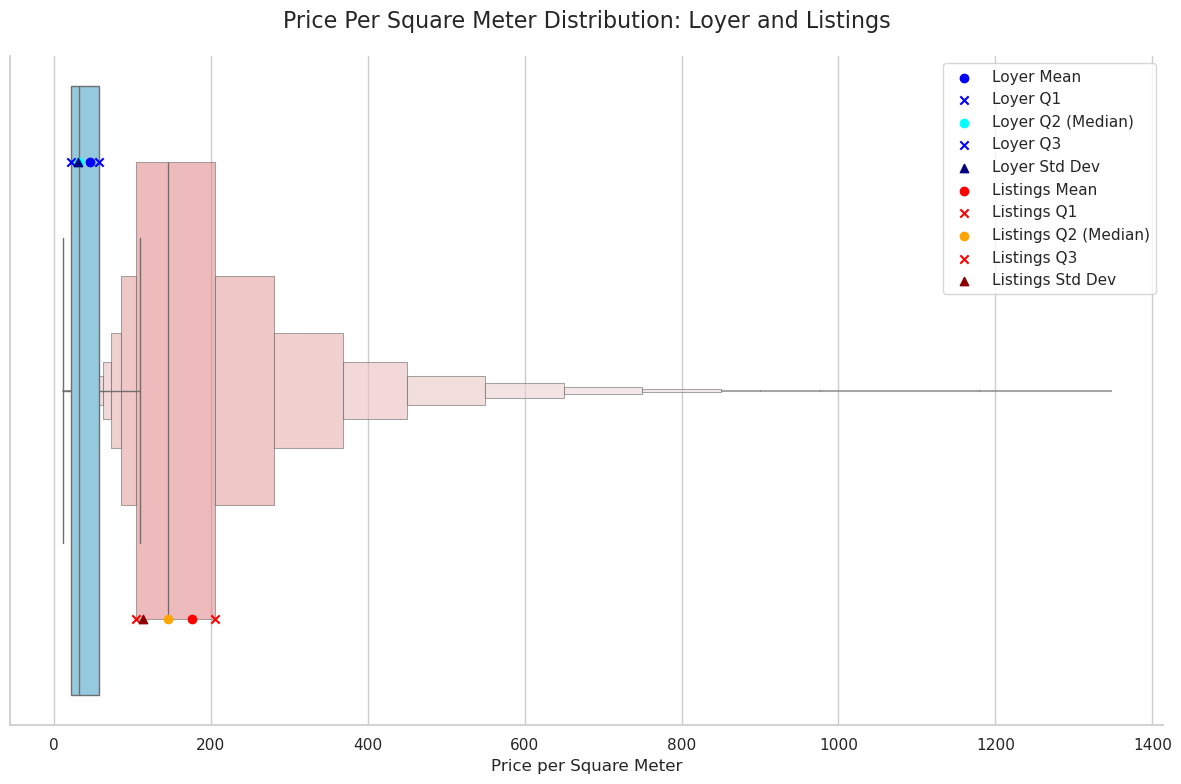

In [84]:
def boxplot_same_graph( loyer_pd, listings_pd):
    # Set a clean, modern style
    sns.set_theme(style="whitegrid")

    # Calculate special points for loyer_pd
    loyer_summary = loyer_pd['price_per_m2'].describe()
    loyer_mean = loyer_pd['price_per_m2'].mean()
    loyer_std = loyer_pd['price_per_m2'].std()

    # Calculate special points for listings_pd
    listings_summary = listings_pd['price_per_m2'].describe()
    listings_mean = listings_pd['price_per_m2'].mean()
    listings_std = listings_pd['price_per_m2'].std()

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the boxplot for 'price_per_m2' in loyer_pd
    sns.boxplot(
        x='price_per_m2', 
        data=loyer_pd, 
        color="skyblue", 
        width=0.4, 
        showfliers=False,  # Hide outliers for clarity
        ax=ax
    )
    ax.scatter(loyer_mean, -0.15, color="blue", label="Loyer Mean", zorder=3)
    ax.scatter(loyer_summary['25%'], -0.15, color="blue", marker="x", label="Loyer Q1", zorder=3)
    ax.scatter(loyer_summary['50%'], -0.15, color="cyan", marker="o", label="Loyer Q2 (Median)", zorder=3)
    ax.scatter(loyer_summary['75%'], -0.15, color="blue", marker="x", label="Loyer Q3", zorder=3)
    ax.scatter(loyer_std, -0.15, color="navy", marker="^", label="Loyer Std Dev", zorder=3)

    # Plot the boxenplot for 'price_per_m2' in listings_pd
    sns.boxenplot(
        x='price_per_m2', 
        data=listings_pd, 
        color="lightcoral", 
        width=0.3, 
        alpha=0.6,  # Slight transparency to show overlap
        showfliers=False,  # Hide outliers for clarity
        ax=ax
    )
    ax.scatter(listings_mean, 0.15, color="red", label="Listings Mean", zorder=3)
    ax.scatter(listings_summary['25%'], 0.15, color="red", marker="x", label="Listings Q1", zorder=3)
    ax.scatter(listings_summary['50%'], 0.15, color="orange", marker="o", label="Listings Q2 (Median)", zorder=3)
    ax.scatter(listings_summary['75%'], 0.15, color="red", marker="x", label="Listings Q3", zorder=3)
    ax.scatter(listings_std, 0.15, color="darkred", marker="^", label="Listings Std Dev", zorder=3)

    # Set titles and labels
    ax.set_title("Price Per Square Meter Distribution: Loyer and Listings", fontsize=16, pad=20)
    ax.set_xlabel("Price per Square Meter", fontsize=12)
    ax.legend(loc="upper right")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

boxplot_same_graph(loyer_pd, listings_pd)

# Export

In [81]:
loyer_pd.to_csv("./work/data/loyer_process.csv", index=False)
listings_pd.to_csv("./work/data/listings_process.csv", index=False)

NameError: name 'loyer_pd' is not defined

# Compare price to disponibility for Airbnb

In [90]:
calendar_df = spark.read.option("header", "true").option("sep", ",").csv("./work/data/calendar-2023.csv")
calendar_df.show(5)
print("Number of rows: ", calendar_df.count())

+----------+----------+---------+-------+--------------+--------------+--------------+
|listing_id|      date|available|  price|adjusted_price|minimum_nights|maximum_nights|
+----------+----------+---------+-------+--------------+--------------+--------------+
|      3109|2023-12-12|        f|$150.00|          NULL|             2|            30|
|      3109|2023-12-13|        f|$150.00|          NULL|             2|            30|
|      3109|2023-12-14|        f|$150.00|          NULL|             2|            30|
|      3109|2023-12-15|        f|$150.00|          NULL|             2|            30|
|      3109|2023-12-16|        f|$150.00|          NULL|             2|            30|
+----------+----------+---------+-------+--------------+--------------+--------------+
only showing top 5 rows

Number of rows:  27134477


In [91]:
# verify that the price is always the same for the same listing_id
calendare_are_full = calendar_df.groupBy("listing_id").agg(count("price").alias("count"), (count("price") == 365).alias("is365"))
calendare_are_full.show(5)
# count if all are is365 is true
calendare_are_full.groupBy("is365").agg(count("is365").alias("count")).show()

# filter only the rows where is365 is true
print("Number of rows: ", calendar_df.count())
calendar_df = calendar_df.join(calendare_are_full, "listing_id").filter(col("is365") == True)
calendar_df = calendar_df.filter(col("listing_id").isNotNull())  
print("Number of rows: ", calendar_df.count())


+----------+-----+-----+
|listing_id|count|is365|
+----------+-----+-----+
|     56662|  365| true|
|    565747|  365| true|
|    586642|  365| true|
|    618419|  365| true|
|    733727|  365| true|
+----------+-----+-----+
only showing top 5 rows

+-----+-----+
|is365|count|
+-----+-----+
| true|70679|
|false| 3648|
+-----+-----+

Number of rows:  27134477
Number of rows:  25797835


### Let's calculate the ratio of disponibility for each airbnb

In [92]:
# count the number of days where the listing is available (available == t or f)
availability_df = calendar_df.groupBy("listing_id", "available").agg(count("available").alias("days_unavailable")).filter(col("available") == "f")
availability_df.show(5)

+----------+---------+----------------+
|listing_id|available|days_unavailable|
+----------+---------+----------------+
|     56662|        f|             176|
|    565747|        f|              70|
|    586642|        f|             306|
|    618419|        f|             365|
|    733727|        f|             363|
+----------+---------+----------------+
only showing top 5 rows



In [93]:
# calculate the percentage of days unavailable
availability_df = availability_df.withColumn("percentage_unavailable", (col("days_unavailable") / 365))
availability_df.show(5)

+----------+---------+----------------+----------------------+
|listing_id|available|days_unavailable|percentage_unavailable|
+----------+---------+----------------+----------------------+
|     56662|        f|             176|    0.4821917808219178|
|    565747|        f|              70|    0.1917808219178082|
|    586642|        f|             306|    0.8383561643835616|
|    618419|        f|             365|                   1.0|
|    733727|        f|             363|    0.9945205479452055|
+----------+---------+----------------+----------------------+
only showing top 5 rows



In [94]:
availability_df.printSchema()
listings_filter_cols_df.printSchema()
# availability_df = availability_df.withColumn("listing_id", col("listing_id").cast(IntegerType()))
# availability_df.sort("listing_id").show(5)
# listings_filter_cols_df = listings_filter_cols_df.withColumn("id", col("id").cast(IntegerType()))
# listings_filter_cols_df.sort("id").show(5)

root
 |-- listing_id: string (nullable = true)
 |-- available: string (nullable = true)
 |-- days_unavailable: long (nullable = false)
 |-- percentage_unavailable: double (nullable = true)

root
 |-- id: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: string (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- amenities: string (nullable = true)
 |-- availability_30: string (nullable = true)
 |-- availability_60: string (nullable = true)
 |-- availability_90: string (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- number_of_rooms: double (nullable = true)
 |-- surface: double (nullable = true)
 

In [95]:
# join with listings_df to get the price
pondered_listings_df = listings_filter_cols_df.join(availability_df, listings_filter_cols_df.id == availability_df.listing_id, "inner")
pondered_listings_df = pondered_listings_df.withColumn("price_per_m2_pondered", col("price_per_m2")*col("percentage_unavailable"))
pondered_listings_df.show(5)


+-------------------+---------------+-----+----------------+------------------+-----------------+------------------+---------------+------------+---------+--------+----+--------------------+---------------+---------------+---------------+----------------+---------------+-------+------------+-------------------+---------+----------------+----------------------+---------------------+
|                 id|      room_type|price|availability_365|         longitude|         latitude|     property_type|      room_type|accommodates|bathrooms|bedrooms|beds|           amenities|availability_30|availability_60|availability_90|availability_365|number_of_rooms|surface|price_per_m2|         listing_id|available|days_unavailable|percentage_unavailable|price_per_m2_pondered|
+-------------------+---------------+-----+----------------+------------------+-----------------+------------------+---------------+------------+---------+--------+----+--------------------+---------------+---------------+--------

In [96]:
pondered_listings_df.toPandas().to_csv("./work/data/pondered_listings_process.csv", index=False)

### Plot with modified price

In [86]:
pondered_pd = pondered_listings_df.toPandas()

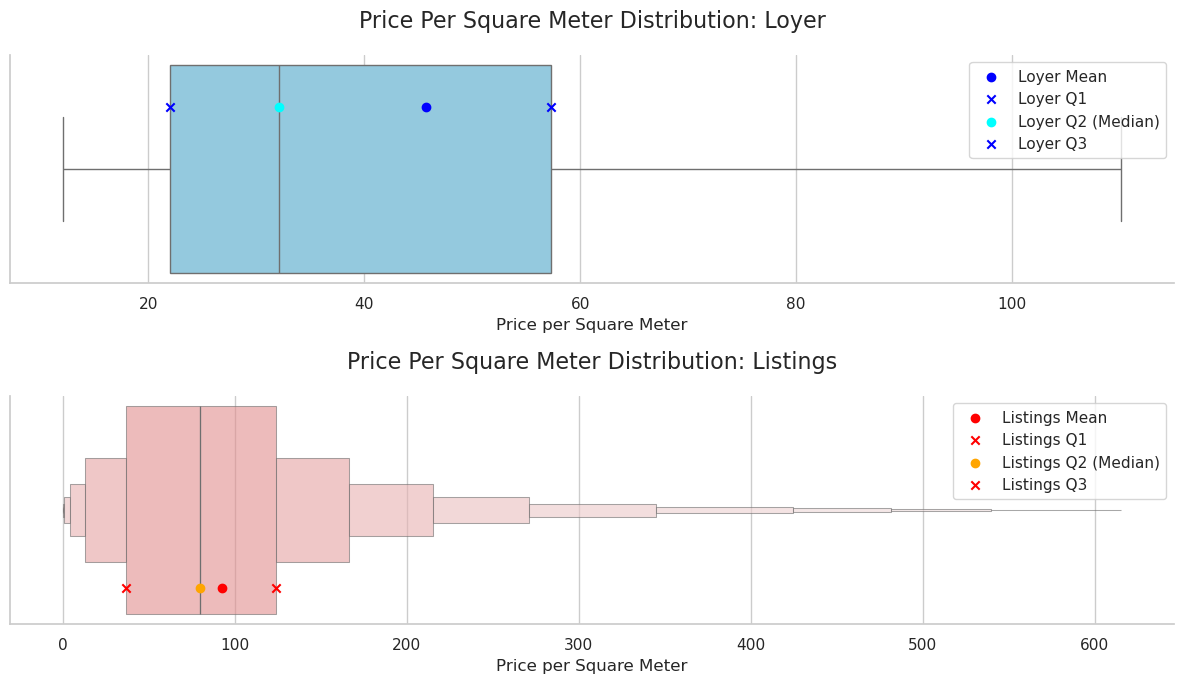

In [87]:
boxplot_different_graph(loyer_pd, pondered_pd)

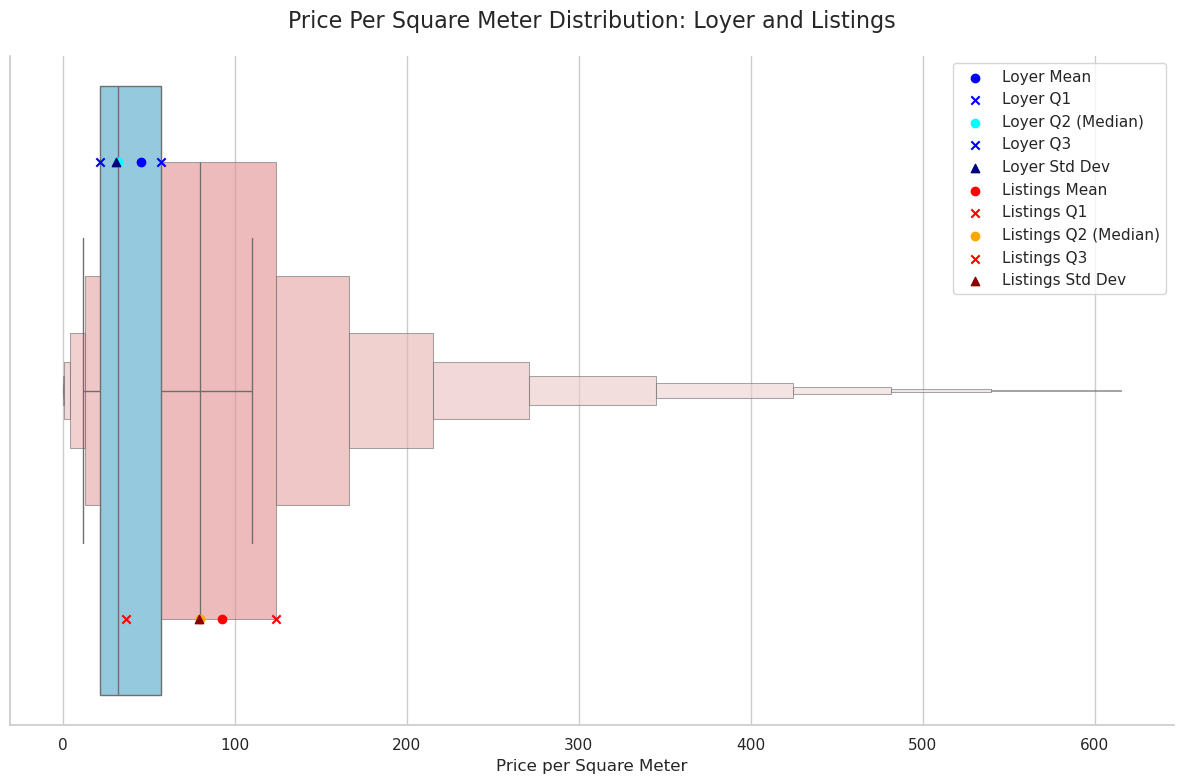

In [88]:
boxplot_same_graph(loyer_pd, pondered_pd)

# Plot price on map with folium

In [ ]:
def map_plot_price(df):
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the scatter plot for 'price_per_m2' in df
    sns.scatterplot(
        x='longitude', 
        y='latitude', 
        data=df, 
        hue='price_per_m2', 
        palette='coolwarm', 
        size='price_per_m2', 
        sizes=(50, 500), 
        alpha=0.7, 
        ax=ax
    )

    # Set titles and labels
    ax.set_title("Price Per Square Meter by Location", fontsize=16, pad=20)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend(title="Price per Square Meter", loc="upper right")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Does amenities have an impact on the price?

In [127]:
# exploration
pondered_listings_df.select("amenities").show(5)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: functions does not exist in the JVM

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [124]:
list_amenity = [
    "Wifi", "Kitchen", "Heating", "Essentials", "Washer", "Hair dryer", "Iron", "Laptop friendly workspace", "Hangers", "TV",
    "Shampoo", "Carbon monoxide alarm", "Smoke alarm", "First aid kit", "Bed linens", "Extra pillows and blankets",
    "Microwave", "Coffee maker", "Refrigerator", "Dishes and silverware", "Cooking basics", "Oven", "Stove", "Long term stays allowed",
    "Host greets you", "Hot water", "Free street parking", "Paid parking off premises", "Private entrance", "Patio or balcony",
    "Garden or backyard", "Luggage dropoff allowed", "Cleaning before checkout", "Single level home", "BBQ grill", "Lockbox",
    "Washer", "Parking", "Air conditioning", "Gym", "Sport", "Heating", "Pool", "Bathtub", "Coffee", "Refrigarator", "Garden", "Balcony",
]
# calculate the mean price per m2 for each amenity
map_amenity_price = {}
for amenity in list_amenity:
    amenity_df = pondered_listings_df.select("amenities", "price_per_m2").withColumn(amenity, col("amenities").contains(amenity).cast("int"))
    count_amenity = amenity_df.groupBy(amenity).agg(count(amenity).alias("count"))
    price_amenity = amenity_df.groupBy(amenity).agg(mean("price_per_m2").alias("mean_price_per_m2"))
    map_amenity_price[amenity] = {}
    map_amenity_price[amenity]["price"] = price_amenity.toPandas().to_json()
    map_amenity_price[amenity]["count"] = count_amenity.toPandas().to_json()


In [125]:
for amenity in list_amenity[0:1]:
    print(amenity)
    for row in map_amenity_price[amenity]:
        print(map_amenity_price[amenity][row])

Wifi
{"Wifi":{"0":1,"1":0},"mean_price_per_m2":{"0":92.1920847246,"1":95.1311108451}}
{"Wifi":{"0":1,"1":0},"count":{"0":6183,"1":568}}


In [126]:
# save the map to json
import json
with open("./work/data/map_amenity_price.json", "w") as f:
    json.dump(map_amenity_price, f)

# Categorize Listings and Loyer to one District

In [29]:
listings_process_df = spark.read.option("header", "true").option("sep", ",").csv("./work/data/listings_process.csv").toPandas()
loyer_process_df = spark.read.option("header", "true").option("sep",",").csv("./work/data/loyer_process.csv").toPandas()

In [25]:
%pip install geopandas shapely

Note: you may need to restart the kernel to use updated packages.


In [30]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [31]:
districts_gdf = gpd.read_file("./work/data/arrondissements/arrondissements.shp")

In [ ]:
listings_points_gdf = gpd.GeoDataFrame(
    listings_process_df,
    geometry=[Point(xy) for xy in zip(listings_process_df["longitude"], listings_process_df["latitude"])],
    crs="EPSG:4326",  # Define the CRS for latitude/longitude
)

loyers_points_gdf = gpd.GeoDataFrame(
    loyer_process_df,
    geometry=[Point(xy) for xy in zip(loyer_process_df["geo_point_2d"].str.split(",", expand=True)[1].astype(float), loyer_process_df["geo_point_2d"].str.split(",", expand=True)[0].astype(float))],
    crs="EPSG:4326",  # Define the CRS for latitude/longitude
)


    ref piece   max   min                           geo_point_2d surface  \
0  23.4     4  28.1  16.4  48.82752745777257, 2.3723977369189355    40.0   
1  30.8     1  37.0  21.6   48.876008290020586, 2.36812301788768    10.0   
2  22.6     4  27.1  15.8   48.85706404083103, 2.380364061726767    40.0   
3  34.0     3  40.8  23.8  48.85526326937375, 2.3255876525808024    30.0   
4  27.8     2  33.4  19.5  48.823452771575106, 2.337070179863054    20.0   

         price_per_m2  
0  17.549999999999997  
1                92.4  
2  16.950000000000003  
3                34.0  
4                41.7  
Index(['ref', 'piece', 'max', 'min', 'geo_point_2d', 'surface',
       'price_per_m2'],
      dtype='object')


In [ ]:
joined_listing_gdf = gpd.sjoin(listings_points_gdf, districts_gdf, how="left", predicate="within")
joined_listing_gdf.head(2)

joined_loyer_gdf = gpd.sjoin(loyers_points_gdf, districts_gdf, how="left", predicate="within")
joined_loyer_gdf.head(2)

,ref,piece,max,min,geo_point_2d,surface_left,price_per_m2,geometry,index_right,n_sq_ar,c_ar,c_arinsee,l_ar,l_aroff,n_sq_co,surface_right,perimetre
0,23.4,4,28.1,16.4,"48.82752745777257, 2.3723977369189355",40.0,17.549999999999997,POINT (2.3724 48.82753),15,750000013,13,75113,13ème Ardt,Gobelins,750001537,7.149311e+06,11546.546526
1,30.8,1,37.0,21.6,"48.876008290020586, 2.36812301788768",10.0,92.4,POINT (2.36812 48.87601),9,750000010,10,75110,10ème Ardt,Entrepôt,750001537,2.891739e+06,6739.375055


In [35]:
listings_process_df["district"] = joined_listing_gdf["c_ar"].astype(int)
loyer_process_df["district"] = joined_loyer_gdf["c_ar"].astype(int)

In [36]:
listings_process_df.to_csv("./work/data/listings_disctrict_process.csv", index=False)
loyer_process_df.to_csv("./work/data/loyers_district_process.csv", index=False)

# Create map of mean price per district

In [72]:
listings_ds_df = spark.read.option("header", "true").option("sep", ",").csv("./work/data/listings_disctrict_process.csv")
loyers_ds_df = spark.read.option("header", "true").option("sep",",").csv("./work/data/loyers_district_process.csv")

In [73]:
mean_listings_ds_df = listings_ds_df.groupBy("district").agg(mean("price_per_m2").alias("mean_price_per_m2"))
mean_loyers_ds_df = loyers_ds_df.groupBy("district").agg(mean("price_per_m2").alias("mean_price_per_m2"))

from pyspark.sql.functions import stddev
std_listings_ds_df = listings_ds_df.groupBy("district").agg(stddev("price_per_m2").alias("std_price_per_m2"))
std_loyers_ds_df = loyers_ds_df.groupBy("district").agg(stddev("price_per_m2").alias("std_price_per_m2"))

In [74]:
# barplot of mean price per m2 for each district
mean_listings_pd = mean_listings_ds_df.toPandas()
mean_loyers_pd = mean_loyers_ds_df.toPandas()
std_listings_pd = std_listings_ds_df.toPandas()
std_loyers_pd = std_loyers_ds_df.toPandas()

In [75]:

def barplot_price_per_m2(mean_listings_pd, mean_loyers_pd, col_name):
    # Set a clean, modern style
    sns.set_theme(style="whitegrid")

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the barplot for 'mean_price_per_m2' in mean_listings_pd
    sns.barplot(
        x='district', 
        y=col_name, 
        data=mean_listings_pd, 
        color="skyblue", 
        alpha=0.7, 
        label="Listings", 
        ax=ax
    )

    # Plot the barplot for 'mean_price_per_m2' in mean_loyers_pd
    sns.barplot(
        x='district', 
        y=col_name, 
        data=mean_loyers_pd, 
        color="lightcoral", 
        alpha=0.7, 
        label="Loyers", 
        ax=ax
    )

    # Set titles and labels
    ax.set_title(f"Price Per Square Meter by District ({col_name})", fontsize=16, pad=20)
    ax.set_xlabel("District", fontsize=12)
    ax.set_ylabel("Price per Square Meter", fontsize=12)
    ax.legend(title="Dataset", loc="upper right")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [79]:

# cast disctrict to int
mean_listings_pd["district"] = mean_listings_pd["district"].astype(int).sort_values()
mean_loyers_pd["district"] = mean_loyers_pd["district"].astype(int).sort_values()

std_listings_pd["district"] = std_listings_pd["district"].astype(int).sort_values()
std_loyers_pd["district"] = std_loyers_pd["district"].astype(int).sort_values()

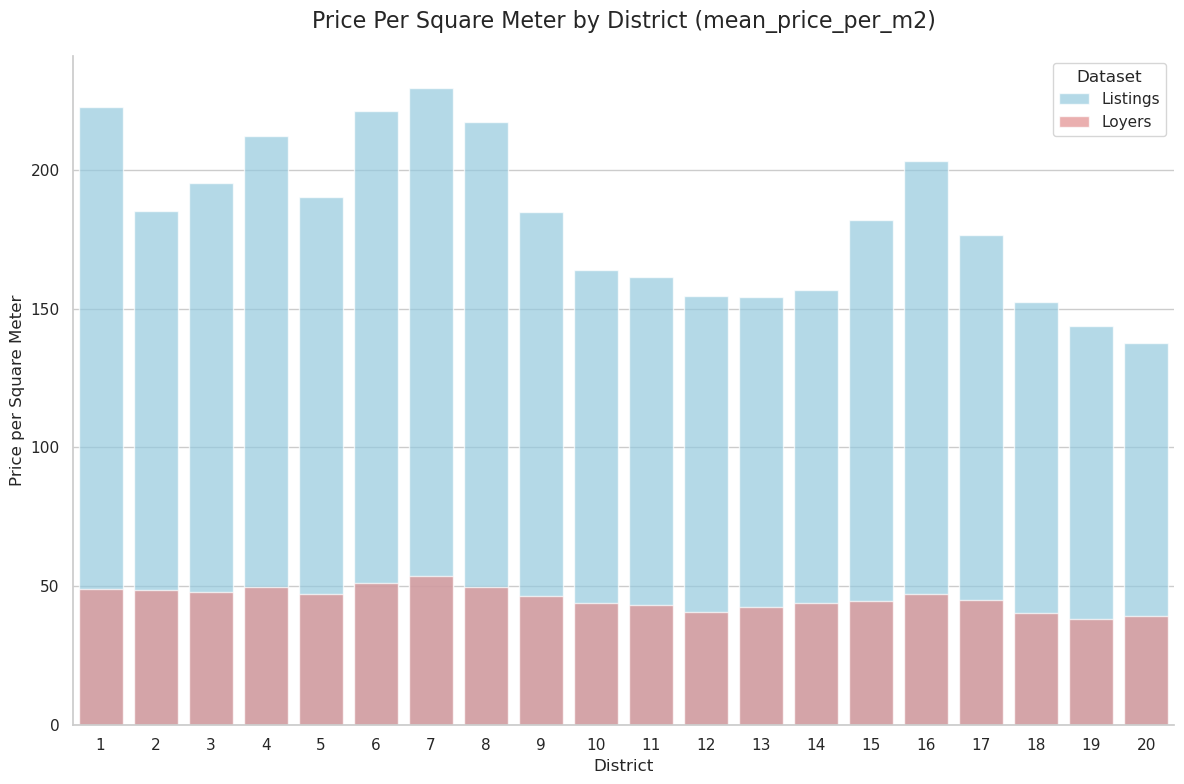

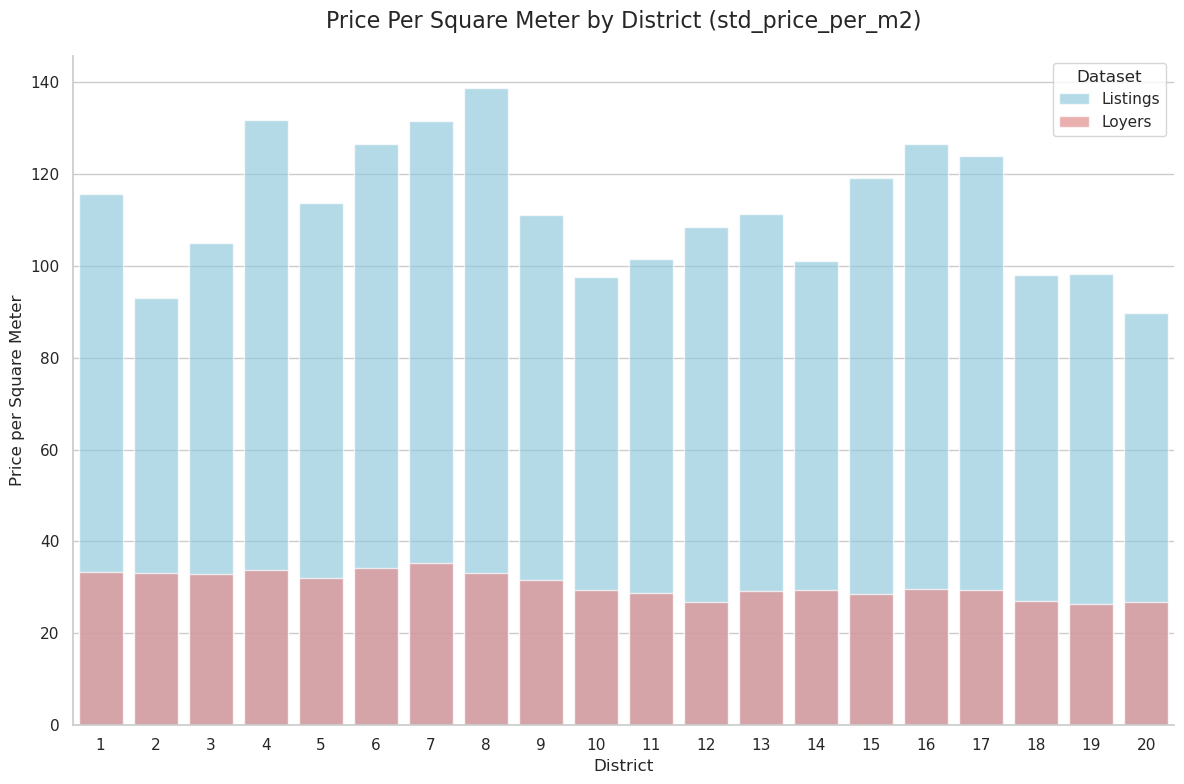

In [80]:
barplot_price_per_m2(mean_listings_pd, mean_loyers_pd, "mean_price_per_m2")
barplot_price_per_m2(std_listings_pd, std_loyers_pd, "std_price_per_m2")